In [5]:
import datetime

import matplotlib.pyplot as plt
import numpy
import pandas
import seaborn
import yfinance

from rfcorr.random_forest import get_corr, get_pairwise_corr

In [6]:
rs = numpy.random.RandomState(42)

In [7]:
# fetch all symbols
symbol_list = ["SPY",
              "XLB",
              "XLE",
              "XLF",
               "XLI",
               "XLK",
               "XLP",
               "XLU",
               "XLV",
               "XLRE",
              ]

symbol_df = yfinance.download(symbol_list, progress=False)
symbol_df = symbol_df.dropna(axis=0)
print(symbol_df.shape)

(1599, 60)


In [8]:
close_close_ret_df = numpy.log(symbol_df.loc[:, "Adj Close"]).diff().iloc[1:]
close_close_ret_df.tail()

,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLRE,XLU,XLV
Date,,,,,,,,,,
2022-02-07,-0.003214,-0.004945,0.012691,0.002988,0.000799,-0.006664,0.001843,0.000214,-0.001461,-0.001740
2022-02-08,0.008194,0.015357,-0.021731,0.013827,0.009932,0.012287,0.003807,-0.009034,0.000731,0.008144
2022-02-09,0.014530,0.021554,0.008313,0.006355,0.013643,0.021938,0.000262,0.023912,0.004375,0.007706
2022-02-10,-0.018129,-0.005843,-0.006265,-0.008811,-0.016513,-0.026497,-0.010800,-0.028895,-0.025643,-0.015774
2022-02-11,-0.016833,-0.011908,0.029806,-0.012118,-0.012667,-0.026511,-0.000530,-0.011576,0.004320,-0.009356


In [20]:
window = 20
start_date = pandas.Timestamp(datetime.date(2021, 1, 1))
start_date_index = [i for i, ix in enumerate(close_close_ret_df.index)
                    if ix >= start_date]
if len(start_date_index) > 0:
    start_date_index = start_date_index[0]
    if start_date_index <= window:
        raise ValueError("start_date and window are not compatible")
else:
    raise ValueError("start_date and data are not compatible")

window_corr_ts_list = []
window_corr_ts_index = []

for window_df in close_close_ret_df.iloc[(start_date_index - window):].rolling(window=window):
    print(window_df.index[-1])
    if window_df.shape[0] == window:
        window_corr_ts_list.append(pandas.DataFrame(get_pairwise_corr(window_df.values,
                                                         num_trees=100,
                                                         lag=1, 
                                                         method="regression",
                                                         random_state=rs),
                                                columns=close_close_ret_df.columns,
                                                index=close_close_ret_df.columns))
        window_corr_ts_index.append(window_df.index[-1])

window_corr_ts_array = numpy.stack(window_corr_ts_list)
print(window_corr_ts_array.shape)

2020-12-03 00:00:00
2020-12-04 00:00:00
2020-12-07 00:00:00
2020-12-08 00:00:00
2020-12-09 00:00:00
2020-12-10 00:00:00
2020-12-11 00:00:00
2020-12-14 00:00:00
2020-12-15 00:00:00
2020-12-16 00:00:00
2020-12-17 00:00:00
2020-12-18 00:00:00
2020-12-21 00:00:00
2020-12-22 00:00:00
2020-12-23 00:00:00
2020-12-24 00:00:00
2020-12-28 00:00:00
2020-12-29 00:00:00
2020-12-30 00:00:00
2020-12-31 00:00:00
2021-01-04 00:00:00
2021-01-05 00:00:00
2021-01-06 00:00:00
2021-01-07 00:00:00
2021-01-08 00:00:00
2021-01-11 00:00:00
2021-01-12 00:00:00
2021-01-13 00:00:00
2021-01-14 00:00:00
2021-01-15 00:00:00
2021-01-19 00:00:00
2021-01-20 00:00:00
2021-01-21 00:00:00
2021-01-22 00:00:00
2021-01-25 00:00:00
2021-01-26 00:00:00
2021-01-27 00:00:00
2021-01-28 00:00:00
2021-01-29 00:00:00
2021-02-01 00:00:00
2021-02-02 00:00:00
2021-02-03 00:00:00
2021-02-04 00:00:00
2021-02-05 00:00:00
2021-02-08 00:00:00
2021-02-09 00:00:00
2021-02-10 00:00:00
2021-02-11 00:00:00
2021-02-12 00:00:00
2021-02-16 00:00:00


<AxesSubplot:title={'center':'Sector-SPY "correlation" time series (method=regression, window=20, lag=1)'}, xlabel='Date', ylabel='Correlation'>

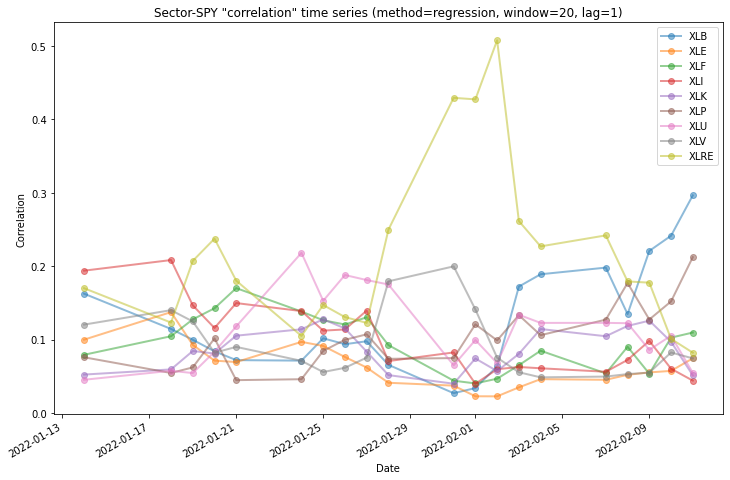

In [64]:
spy_index = symbol_list.index("SPY")
spy_corr_ts = pandas.DataFrame(window_corr_ts_array[:, spy_index, :], 
                 columns=symbol_list,
                 index=window_corr_ts_index)\
    .drop("SPY", axis=1)

f, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_title("Sector-SPY \"correlation\" time series (method=regression, window=20, lag=1)")
ax.set_ylabel("Correlation")
ax.set_xlabel("Date")
spy_corr_ts.tail(20).plot(ax=ax, linewidth=2, alpha=0.5, marker="o")